In [1]:
import layoutparser as lp
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt
import pytesseract
import re

In [ ]:
from io import BytesIO

In [4]:
conf = {'model_path': 'lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', \
        'extra_config':["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],\
        'label_map': {0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}}

In [3]:
def resize_image(path):
    img = Image.open(path)
    width, height = img.size

    new_height = height*4
    new_width  = int(new_height * width / height)

    img = img.resize((new_width,new_height), Image.ANTIALIAS)
    sub_fold_path = '/'.join(path.split('/')[:-1])+'/resized/'
    if not os.path.exists(sub_fold_path):
        os.mkdir(sub_fold_path)
    new_file_path = sub_fold_path+'packaging_info_resized.png'
    img.save(new_file_path)
    return new_file_path

In [24]:
class LayoutParser_process():
    
    def __init__(self, conf):
        model_path = conf['model_path']
        extra_config = conf['extra_config']
        label_map = conf['label_map']
        self.model = lp.Detectron2LayoutModel(model_path, 
                                 extra_config = extra_config,
                                 label_map = label_map)
    
    def detect_header(self, image_path, crop = False, crop_h_range = None, crop_w_range = None, object_block = 'Title'):
        image = cv2.imread(image_path)
        image = image[..., ::-1] 
        if crop:
            if crop_h_range != None:
                image = image[crop_h_range[0]:crop_h_range[1],:,:]
            else:
                if crop_w_range != None:
                    image = image[:,crop_w_range[0]:crop_w_range[1],:]
                else:
                    raise ValueError("Please provide a valid crop height/width or both as crop_h_range or crop_w_range")
            if crop_w_range != None:
                image = image[:,crop_w_range[0]:crop_w_range[1],:]
            else:
                if crop_h_range != None:
                    image = image[crop_h_range[0]:crop_h_range[1],:,:]
                else:
                    raise ValueError("Please provide a valid crop height/width or both as crop_h_range or crop_w_range")

            if ((crop_h_range != None)&(crop_w_range != None)):
                image = image[crop_h_range[0]:crop_h_range[1],crop_w_range[0]:crop_w_range[1],:]

        layout = self.model.detect(image)
        #text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
        title_blocks = lp.Layout([b for b in layout if b.type==object_block])

        return lp.draw_box(image, title_blocks, box_width=3), self.detect_text_from_image(image, title_blocks)

    def detect_text_from_image(self, image, blocks):
        ocr_agent = lp.TesseractAgent(languages='eng')
        for block in blocks:
            segment_image = (block
                               .pad(left=5, right=5, top=5, bottom=5)
                               .crop_image(image))

            text = ocr_agent.detect(segment_image)
            block.set(text=text, inplace=True)

        titles = []
        for txt in blocks.get_texts():
            print(txt, end='\n---\n')
            txt_ = txt.split("\n")[0]
            txt_ = re.sub(r"[^a-zA-Z0-9]+"," ",txt_)
            txt_ = txt_.strip()
            titles.append(txt_)
        return titles

In [25]:
layp = LayoutParser_process(conf)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [26]:
im, headers = layp.detect_header("other_datasheet_images/im0.jpg")

APPLICATIONS

---
.P® Commercial Inductors, High Saturation Series

---
DESIGN SUPPORT TOOLS click logo to get started

---
FEATURES

---


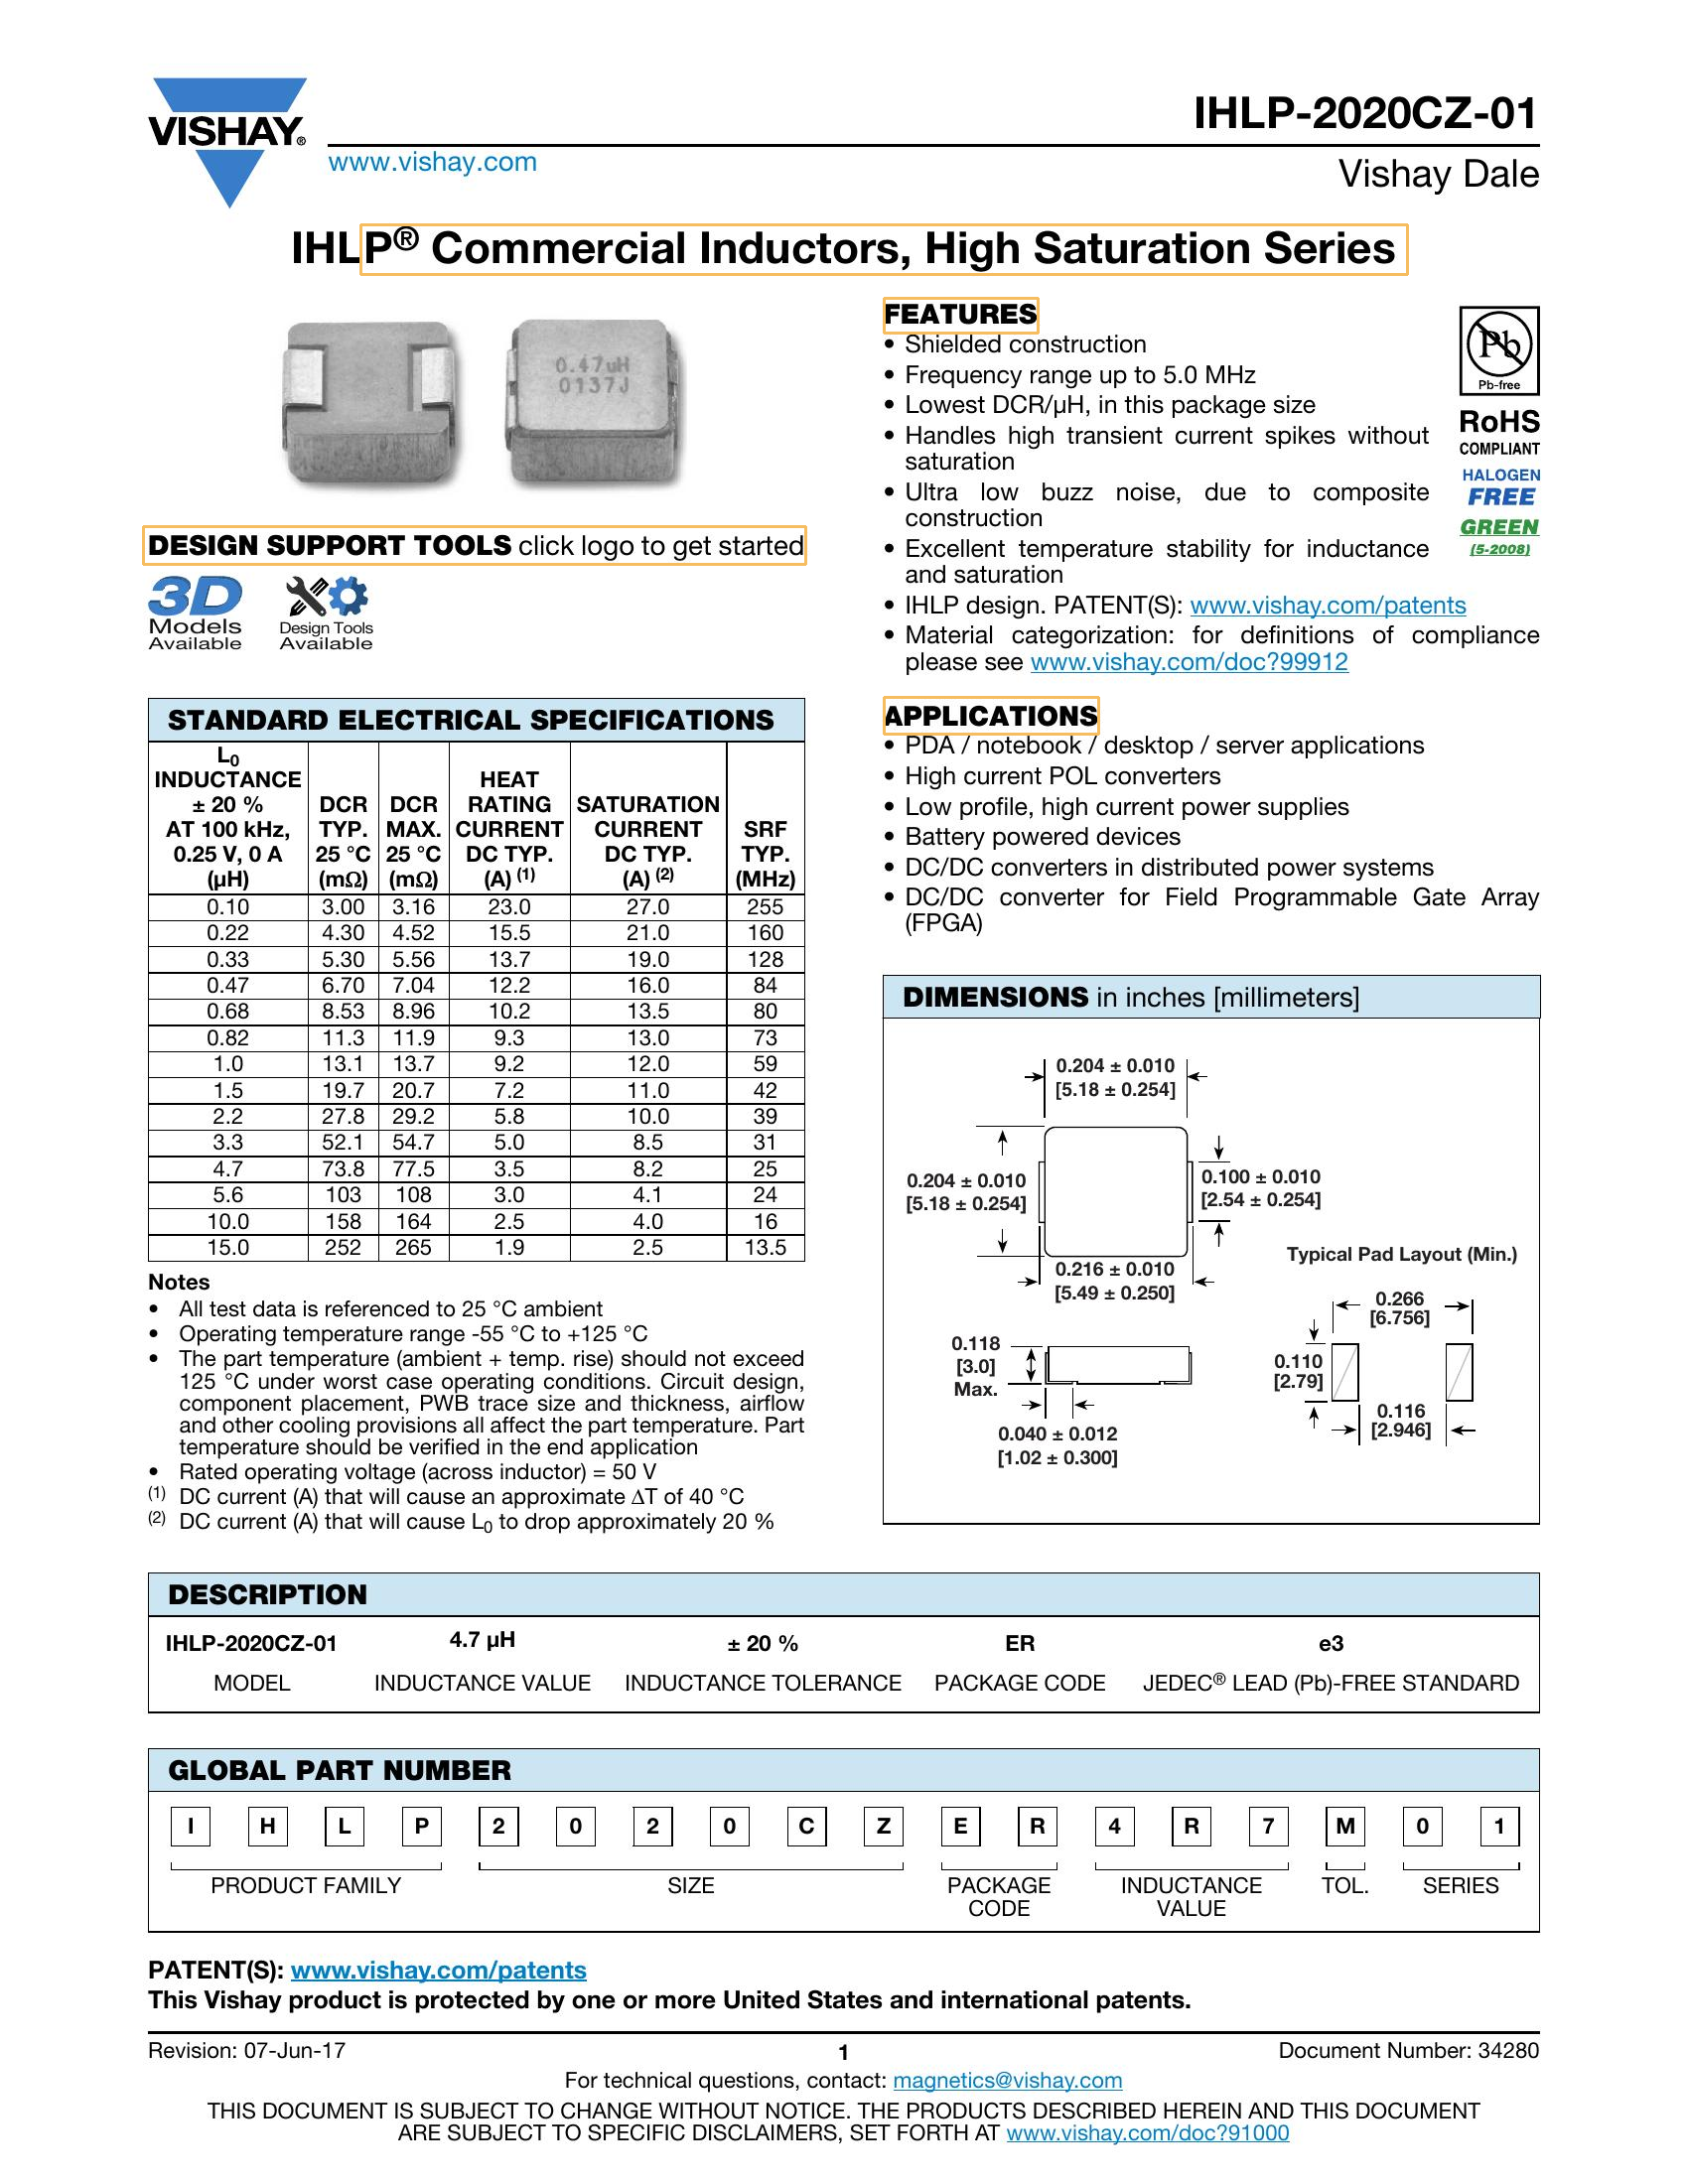

In [27]:
im

In [28]:
headers

['APPLICATIONS',
 'P Commercial Inductors High Saturation Series',
 'DESIGN SUPPORT TOOLS click logo to get started',
 'FEATURES']

In [29]:
im, headers = layp.detect_header("TI_datasheet_images/im3.jpg")

ELECTROSTATIC DISCHARGE (ESD) PROTECTION

 

---
ABSOLUTE MAXIMUM RATINGS")

---
RECOMMENDED OPERATING CONDITIONS

 

---
ELECTRICAL CHARACTERISTICS

---


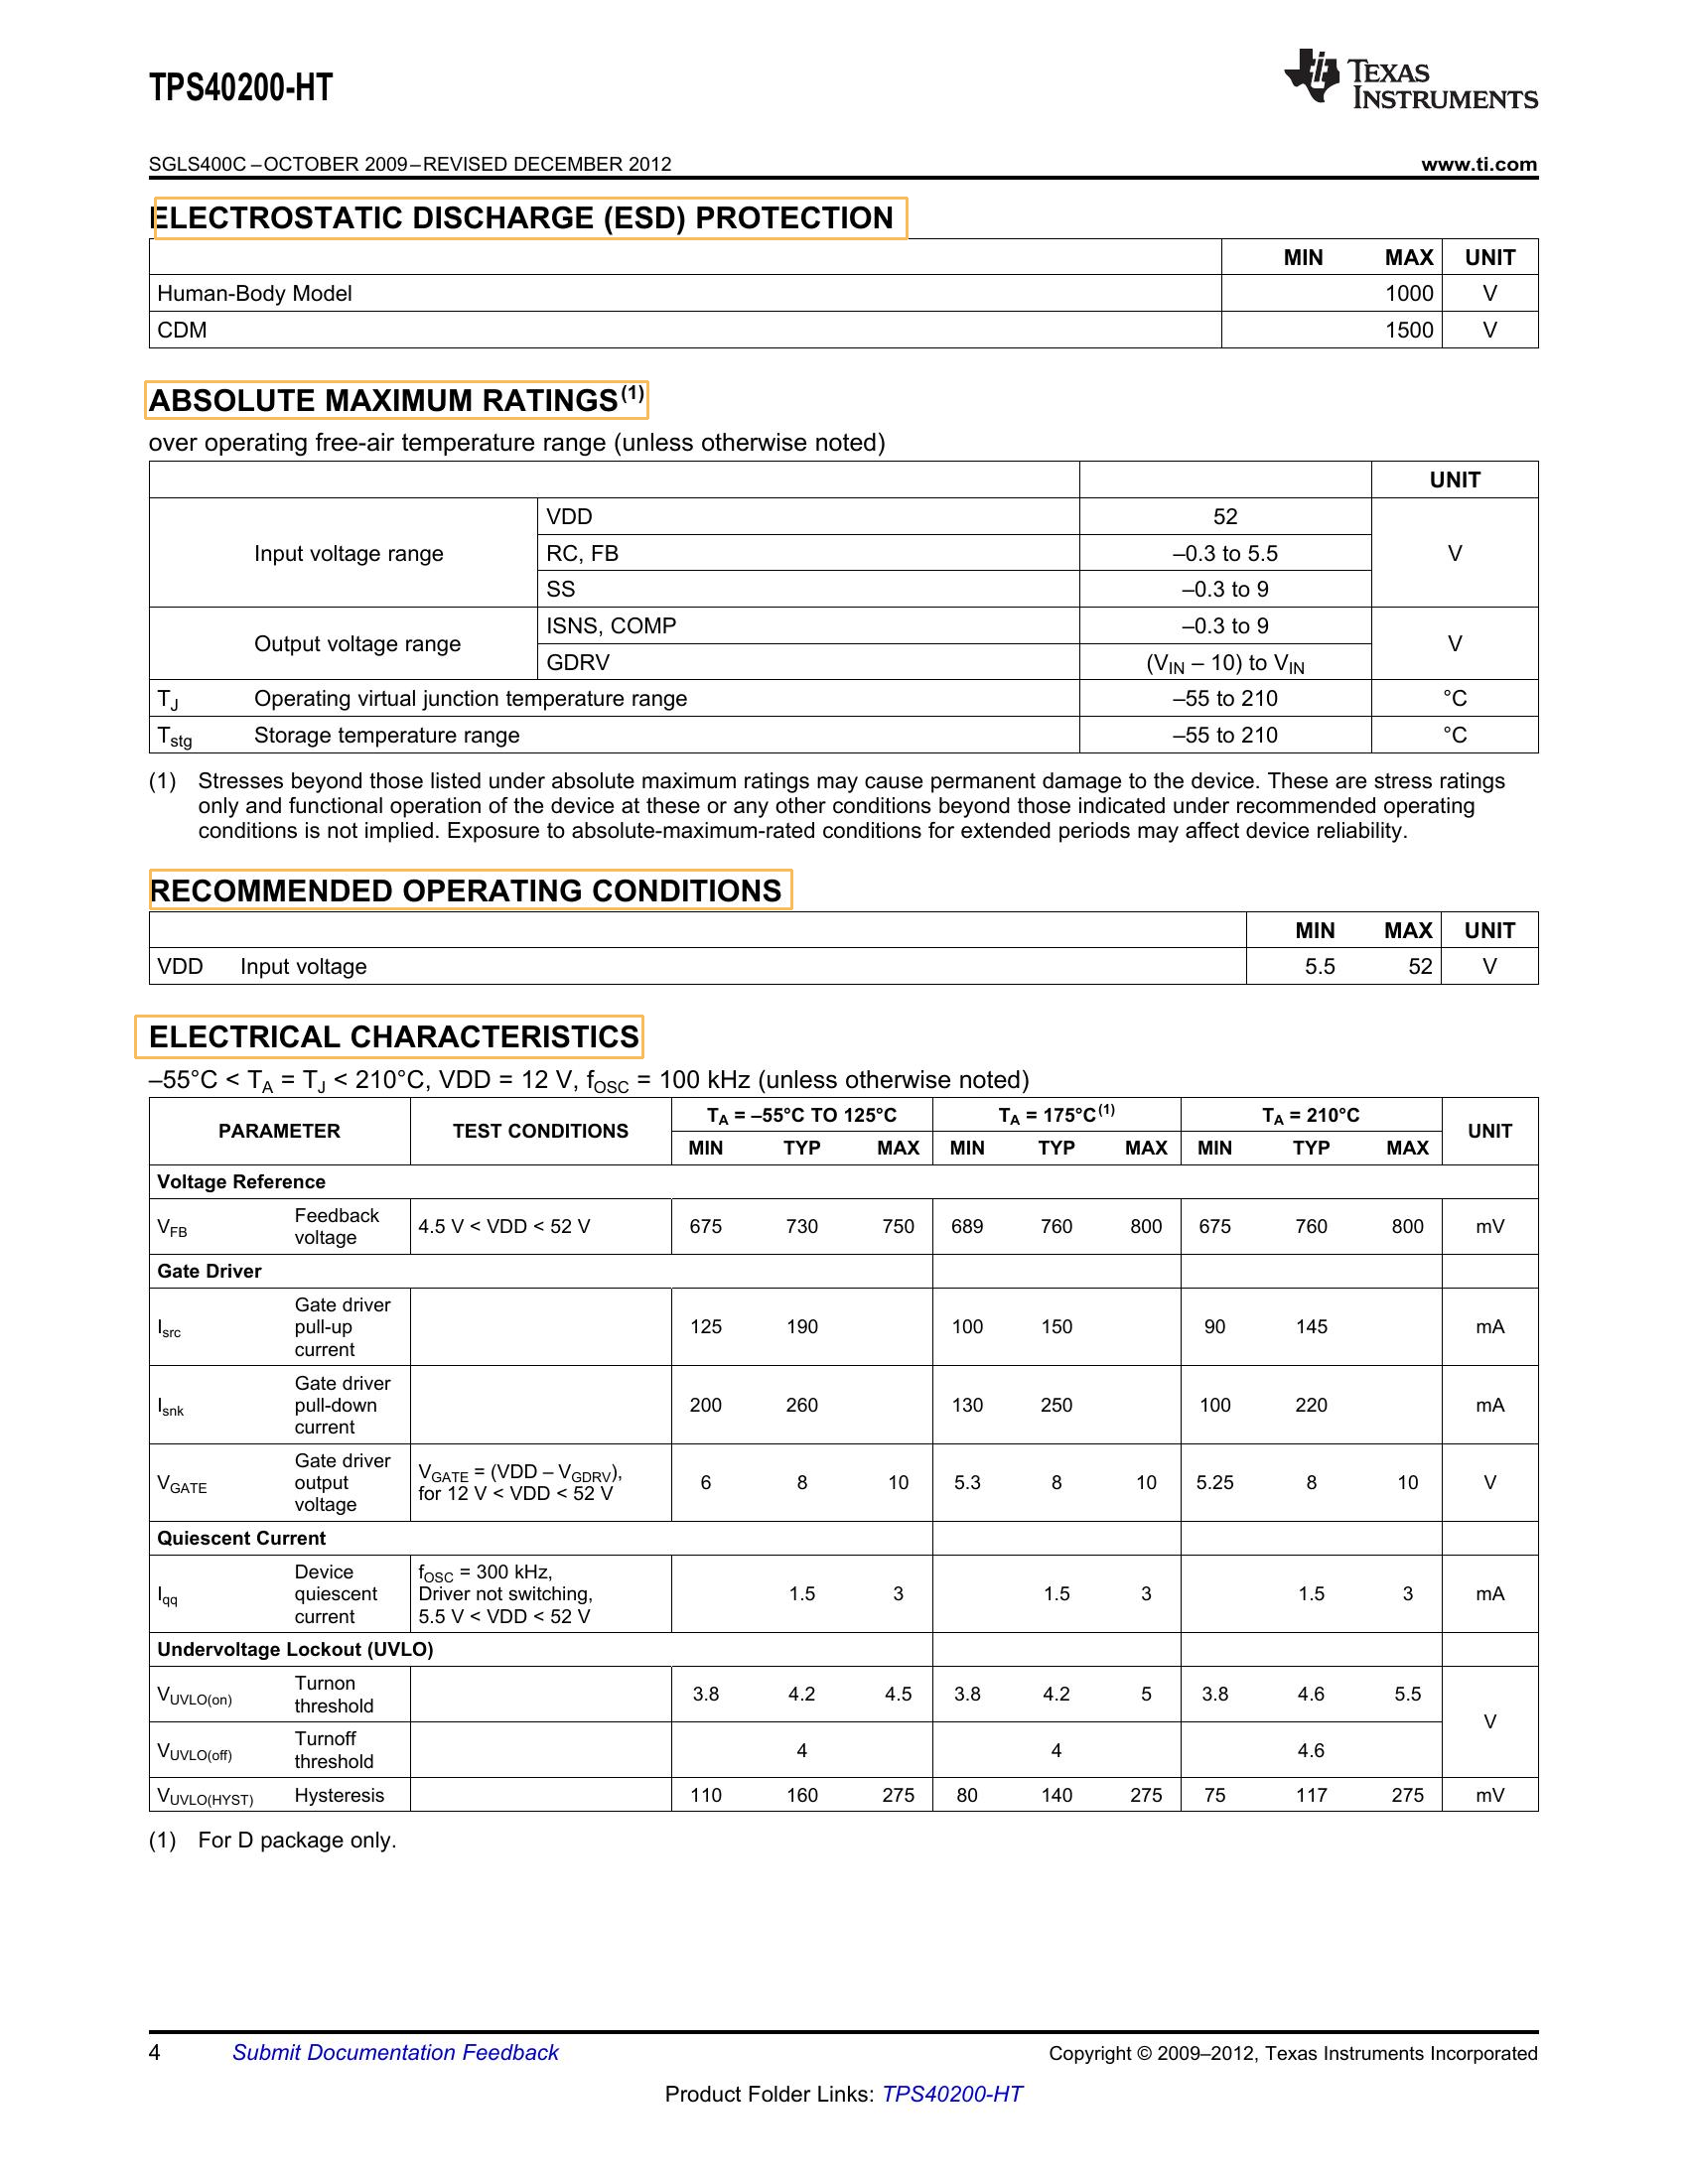

In [30]:
im

In [31]:
[i.split("\n")[0] for i in headers]

['ELECTROSTATIC DISCHARGE ESD PROTECTION',
 'ABSOLUTE MAXIMUM RATINGS',
 'RECOMMENDED OPERATING CONDITIONS',
 'ELECTRICAL CHARACTERISTICS']

In [2]:
from layout.src.detect_layout import LayoutParser_process

In [3]:
fd = open('layout/TI_datasheet_images/im3.jpg', "rb") #encoding="Latin-1")
img_str = fd.read()
fd.close()

In [5]:
lp = LayoutParser_process(conf)

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [6]:
im, h = lp.detect_header_v2(img_str)

/root/anaconda3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


ELECTROSTATIC DISCHARGE (ESD) PROTECTION

 

---
ABSOLUTE MAXIMUM RATINGS")

---
RECOMMENDED OPERATING CONDITIONS

 

---
ELECTRICAL CHARACTERISTICS

---
